In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0].split('-')

year_ago = dt.date(int(most_recent[0]), int(most_recent[1]), int(most_recent[2])) - dt.timedelta(days=365)

past_year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= str(year_ago)).all()


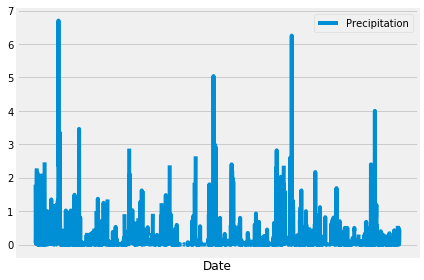

In [11]:
date = [row[0] for row in past_year_data]
precip = [row[1] for row in past_year_data]

df = pd.DataFrame({'Date':date,
                  'Precipitation':precip})

df = df.set_index('Date', inplace=False)
df = df.sort_index()
#df = df.groupby('Date').sum()
df.plot()
plt.xticks([])
#plt.rcParams["figure.figsize"] = (10, 10)
#plt.figure(figsize=(4,20))
plt.tight_layout()
#plt.show()

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
print(f"There are {stations} stations in the dataset.")

There are 9 stations in the dataset.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for row in active_stations:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_set = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station == 'USC00519281')
for row in temp_set:
    print(row)

(54.0, 85.0, 71.66378066378067)


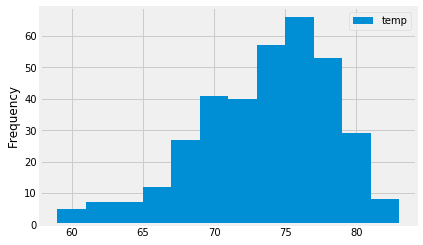

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
                filter(Measurement.date >= str(year_ago)).all()
temp = [row[0] for row in station_temp]
temp_df = pd.DataFrame({'temp':temp})
temp_df.plot(kind='hist', bins=12)
plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tripTemp = calc_temps('2011-02-28', '2011-03-05')
minTemp = tripTemp[0][0]
avgTemp = tripTemp[0][1]
maxTemp = tripTemp[0][2]
trip_df = pd.DataFrame({'Trip Temp (F)':avgTemp}, index=['Last Year'])
#trip_df = trip_df.set_index('Last Year', inplace=False)
print(tripTemp)
trip_df.head()

[(61.0, 69.75510204081633, 75.0)]


,Trip Temp (F)
Last Year,69.755102


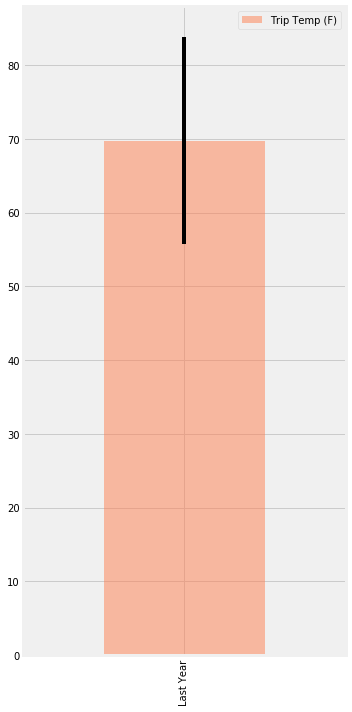

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df.plot(kind='bar', yerr=(maxTemp-minTemp), figsize=(5,10), color='coral', alpha=0.5)
plt.tight_layout()
plt.show()

In [53]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
results = session.query(*sel).filter(Station.station == Measurement.station).filter(Measurement.date >= '2011-02-28').\
        filter(Measurement.date <= '2011-03-05').group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 2.33), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.23), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.19), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.96), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.45), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.44), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.38), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.63), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [62]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [67]:
dateList = []
monthDayList = []
for date in pd.date_range(start='2011-02-28', end='2011-03-05'):
    dateList.append(date.strftime("%Y-%m-%d"))
    monthDayList.append(date.strftime("%m-%d"))
print(dateList)
print(monthDayList)

normals = []
for day in monthDayList:
    normals.append(daily_normals(day)[0])
    
print(normals)

['2011-02-28', '2011-03-01', '2011-03-02', '2011-03-03', '2011-03-04', '2011-03-05']
['02-28', '03-01', '03-02', '03-03', '03-04', '03-05']
[(65.0, 70.65517241379311, 80.0), (64.0, 70.0327868852459, 76.0), (61.0, 70.36666666666666, 78.0), (60.0, 70.06896551724138, 78.0), (57.0, 69.27272727272727, 77.0), (60.0, 67.89090909090909, 76.0)]


In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [71]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tripNormals_df = pd.DataFrame({'tmin':[row[0] for row in normals],
                              'tavg':[row[1] for row in normals],
                              'tmax':[row[2] for row in normals],
                              'date':dateList})
tripNormals_df = tripNormals_df.set_index('date', inplace=False)
tripNormals_df.head()

,tmin,tavg,tmax
date,,,
2011-02-28,65.0,70.655172,80.0
2011-03-01,64.0,70.032787,76.0
2011-03-02,61.0,70.366667,78.0
2011-03-03,60.0,70.068966,78.0
2011-03-04,57.0,69.272727,77.0


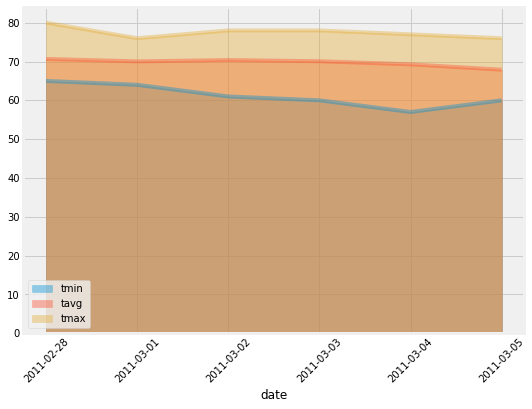

In [82]:
# Plot the daily normals as an area plot with `stacked=False`
ax = tripNormals_df.plot(kind='area', stacked=False, figsize=(8,6), alpha=0.4)
plt.xticks(range(len(tripNormals_df.index)),tripNormals_df.index, rotation=45)
plt.show()